In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Lambda, Conv2D, Dropout, Multiply, GlobalMaxPooling2D, MaxPooling2D, TimeDistributed, LSTM, Conv2DTranspose, concatenate, Concatenate, Dense, BatchNormalization, Activation, SeparableConv2D, add, Add, Multiply, SeparableConv2D, GlobalAveragePooling2D, DepthwiseConv2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt


# set global random seed
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
# Check if TensorFlow is using the Metal plugin (I'm using a Macbook Air with a built in 16-core Neural Engin, want to make sure I'm using that to ensure faster runtime)
print("TensorFlow is using Metal:", tf.config.list_physical_devices('GPU'))

TensorFlow is using Metal: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Preprocessing

In [3]:
# ---- Global Variables and Methods----
IMAGE_FOLDER = "images/"
SAL_MAP_FOLDER = "saliency_maps/"
CSV_FILE = 'image_types.csv'
IMG_SIZE = (224, 224, 3)

In [4]:
# ---- Data Generator ----
class DataGenerator(tf.keras.utils.Sequence):
    '''
    A custom data loader for the UI images and saliency maps, inheriting from tf.keras.utils.Sequence.
    For instance, can be used with the following methods:
        model.fit(train_data_gen, validation_data=val_data_gen, ...)
        predictions = model.predict(data_gen)
        loss, mae = model.evaluate(data_gen)
    '''
    def __init__(self, image_folder, sal_map_folder, filenames, batch_size=1, shuffle=True, sample_size=None):
        '''
        Constructor:
            image_folder (str): Path to the folder containing input images.
            sal_map_folder (str): Path to the folder containing saliency maps.
            filenames (list): List of filenames to include in this generator.
            batch_size (int): Number of samples per batch.
            shuffle (bool): Whether to shuffle the data at the end of each epoch.
            sample_size (int): Number of samples to use (for debugging).
        '''
        self.image_folder = image_folder # string, path to the folder containing input images
        self.sal_map_folder = sal_map_folder # string, path to the folder containing saliency maps
        self.batch_size = batch_size # int, number of samples per batch
        self.filenames = filenames # list of filenames (shared between the input images and their corresponding saliency maps) to convert to data
        self.sample_size = sample_size
        self.shuffle = shuffle # boolean, if using random shuffle each epoch

        # Limit the dataset to a (smaller) sample_size if specified
        if self.sample_size and self.sample_size<len(self.filenames):
            self.filenames = self.filenames[:self.sample_size]

        self.on_epoch_end() # random shuffle

    def on_epoch_end(self): # if using random shuffle each epoch
        '''If shuffle=True, shuffles the list of filenames to randomize the order of data for the next epoch (automatically called by Keras)'''
        if self.shuffle:
            np.random.shuffle(self.filenames)

    def __len__(self):
        '''Returns the number of batches per epoch'''
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        '''
        Generates one batch of data given the index of the batch (automatically called by Keras)
        Returns tuple (X, Y), both normalized to [0,1]
        X: batch of input images of shape (batch_size, height, width, channels)
        Y: batch of corresponding saliency maps of shape (batch_size, height, width, 1)
        
        Can be called using the [] indexing operator
        '''
        # select a subset of filenames for the current batch
        batch_files = self.filenames[index * self.batch_size:(index + 1) * self.batch_size]

        # load and preprocess the images and saliency maps for the specified batch
        return self.__data_generation(batch_files)
    
    def __data_generation(self, batch_files):
        '''
        Load and preprocess the images and saliency maps.
        Returns tuple (X, Y), both normalized to [0,1]
        X: batch of input images of shape (batch_size, height, width, channels)
        Y: batch of corresponding saliency maps of shape (batch_size, height, width, 1)
        '''
        X, Y = [], []
        for file in batch_files:
            # UI image
            img_path = os.path.join(self.image_folder, file)
            img = load_img(img_path, target_size=IMG_SIZE[:2]) # load and resize image to IMG_SIZE
            img = img_to_array(img) / 255.0 # convert images to arrays and normalize them to [0,1]
            
            # corresponding saliency map (grayscale)
            sal_path = os.path.join(self.sal_map_folder, file)
            sal_img = load_img(sal_path, target_size=IMG_SIZE[:2], color_mode="grayscale") # load and resize image to IMG_SIZE
            sal_img = img_to_array(sal_img) / 255.0 # convert images to arrays and normalize them to [0,1], use normalize()????
            
            X.append(img)
            Y.append(sal_img)

        return np.array(X), np.array(Y) # convert from list to np.arrays
    
    def saliency_binary_proportion(self):
        '''
        Calculates the average proportion of pixel values > 0.5 to pixel values <= 0.5
        in the target saliency maps (Y) across all batches in the generator.
        '''
        proportion = 0.0
        n_batches = len(self)
        N = IMG_SIZE[0]*IMG_SIZE[1] # image size, total number of pixels per map

        for i in range(n_batches):
            # Get the current batch of data
            _, Y = self[i]
            
            # Calculate the number of pixels > 0.5 in the saliency maps (Y)
            pixels_gt_0_5 = np.sum(Y > 0.5)

            # The total number of pixels in the saliency maps (Y)
            total_pixels = self.batch_size*N
            
            # Accumulate the proportion of salient pixels
            proportion += (pixels_gt_0_5 / total_pixels)

        # Calculate the average proportion across all batches
        return proportion / n_batches

In [5]:
# ---- Handle Missing Data ----
# Load the CSV file into a DataFrame
df = pd.read_csv(CSV_FILE, sep=',')

# Get the list of filenames from the CSV file, the image folder, and the saliency map folder
csv_filenames = set(df["Image Name"])
image_filenames = set(os.listdir(IMAGE_FOLDER))
sal_map_filenames = set(os.listdir(SAL_MAP_FOLDER))

print(f"There are {len(csv_filenames)} filenames in the CSV file.")
print(f"There are {len(image_filenames)} filenames in the Image folder.")
print(f"There are {len(sal_map_filenames)} filenames in the Saliency Map folder.")


# Find filenames that are missing in any of the three locations
missing_files = (csv_filenames | image_filenames | sal_map_filenames) - (csv_filenames & image_filenames & sal_map_filenames)

# Print missing filenames
if missing_files:
    print("The following filenames are missing in one or more locations:")
    for filename in missing_files:
        print(filename)
else:
    print("All filenames are present in all three locations.")

# Remove missing filenames from the CSV file
df = df[~df['Image Name'].isin(missing_files)]

print(f"Removed {len(missing_files)} filenames from the CSV file.\n")
print(f'Remaining Number of Data Samples:{df.shape[0]}')
print(f'Remaining Number of Desktop Samples:{df[df["Category"] == "desktop"].shape[0]}')
print(f'Remaining Number of Mobile Samples:{df[df["Category"] == "mobile"].shape[0]}')
print(f'Remaining Number of Web Samples:{df[df["Category"] == "web"].shape[0]}')
print(f'Remaining Number of Poster Samples:{df[df["Category"] == "poster"].shape[0]}')

There are 1463 filenames in the CSV file.
There are 1483 filenames in the Image folder.
There are 1924 filenames in the Saliency Map folder.
The following filenames are missing in one or more locations:
dba9fe.png
4d17b7.jpg
e3d6fa.png
5c88b8.png
35bd1e.png
c9e860.png
da36d4.jpg
e663f9.png
49e0ba.png
0529f2.png
576a9f.jpg
adbe00.png
eb34f4.png
7bed0d.png
e74016.png
fbd704.png
ab56ac.png
abc926.png
7ac1c6.png
c71a6f.png
c053d2.jpg
6e09d5.jpg
ea0f94.png
e332da.jpg
e277d3.jpg
cca312.jpg
529ce0.png
d85242.png
ac484e.png
ccf32c.png
81627a.png
c40b98.jpg
cced5f.jpg
cc5387.png
d355a9.jpg
075286.png
cdcaf8.jpg
d4430e.png
6eb097.png
c2a57a.png
6fd016.jpg
e78858.png
de022a.png
cbd84a.jpg
4e2a75.jpg
76822c.png
7c5f7f.jpg
6d8534.png
56669a.jpg
5b04c4.png
fb0956.png
a47405.png
e129e6.jpg
4d3cc1.png
cc9bc8.png
eb06ec.jpg
33d2a6.png
5b5e85.jpg
6e6daf.jpg
598d81.jpg
aa6f23.jpg
d7346d.png
79672d.jpg
e017a7.png
e9465f.jpg
4bcfc3.png
7c98c6.png
e39798.png
e2f692.png
ea104d.jpg
e69624.jpg
c50a3d.png
f13c2

In [6]:
# ---- Initialize DataLoaders ----

# Filter by category if needed (desktop, poster, mobile, web) !!!
df = df[df['Category'] == "desktop"]

# Split the training data by randomly selecting valid_size*100% of the training data for validation
train_files = df[df['Train/Test'] == 'Train']['Image Name'].tolist()
valid_size = 0.2 # Split ratio
valid_indices = np.random.choice(len(train_files), int(len(train_files) * valid_size), replace=False)

# Get the list of...
valid_files = [train_files[i] for i in valid_indices] # validation filenames
train_files = [train_files[i] for i in range(len(train_files)) if i not in valid_indices] # training filenames
test_files = df[df['Train/Test'] == 'Test']['Image Name'].tolist() # testing filenames

# Check the number of batches in each generator
print("Number of training samples:", len(train_files))
print("Number of validation samples:", len(valid_files))
print("Number of test samples:", len(test_files))

# Initialize the training, validation, testing DataGenerators
train_data_gen = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, train_files, batch_size = 16)
valid_data_gen = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, valid_files, shuffle=False, batch_size = 16) # no need to shuffle validation data
test_data_gen = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, test_files, shuffle=False, batch_size = 16) # no need to shuffle test data

# Check the number of batches in each generator
print("Number of training batches:", len(train_data_gen))
print("Number of validation batches:", len(valid_data_gen))
print("Number of test batches:", len(test_data_gen))

# View the first batch of training data
batch1 = train_data_gen[0]
print("Training input batch shape:", batch1[0].shape)
print("Training saliency batch shape:", batch1[1].shape)

# View the average proportion of salient pixels in target maps of training data
print('Average proportion of salient pixels in target maps: ', train_data_gen.saliency_binary_proportion())

Number of training samples: 276
Number of validation samples: 69
Number of test samples: 18
Number of training batches: 17
Number of validation batches: 4
Number of test batches: 1
Training input batch shape: (16, 224, 224, 3)
Training saliency batch shape: (16, 224, 224, 1)
Average proportion of salient pixels in target maps:  0.027322427994635357


using 0.5 as a binary classification threshold for pixel saliency, even though this isn't a classification problem, this illustrates how sparse the target output is (like how class imbalance in target data is difficult)

# Defining Methods for Evaluating the Model Training Process and Performance

In [7]:
# Plot the learning curve
def plot_learning_curve(history):
    # Extract loss and metrics from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    # Plot the loss curve (use combined loss!!!)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
        
    plt.tight_layout()
    plt.show()

In [8]:
# Function to visualize the original image, ground truth saliency map, and predicted saliency map
def visualize_results(model, data_gen, num_samples=5):
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        # Get a new batch for each sample
        X, Y_sal = data_gen[i % len(data_gen)]  # Cycle through batches if num_samples > batch_size
        
        # Predict saliency map
        Y_pred = model.predict(X, verbose=0)
        
        # Original Image (already resized to IMG_SIZE in DataGenerator)
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X[0])  # Only use the first sample in the batch
        plt.title("Original Image")
        plt.axis('off')
        
        # Ground Truth Saliency Map (already resized to IMG_SIZE in DataGenerator)
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(Y_sal[0].squeeze(), cmap='gray')  # Only use the first sample in the batch
        plt.title("Ground Truth Saliency Map")
        plt.axis('off')
        
        # Predicted Saliency Map (already resized to IMG_SIZE in DataGenerator)
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(Y_pred[0].squeeze(), cmap='gray')  # Only use the first sample in the batch
        plt.title("Predicted Saliency Map")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Defining the Loss Terms and Model Evaluation Metrics

### Define various normalization and scaling functions

In [9]:
# ----------------------------- Scaling Functions ----------------------------- 

def batch_min_max_scaling(heatmap):
    '''
    Min-Max scaling
    This method is from 'sal_imp_utilities.py' written by the UEyes team, called 'normalize'.
    '''

    # Apply mimaxscaler algorithm (https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization))
    heatmap = (heatmap - K.min(heatmap)) / (K.epsilon() + K.max(heatmap) - K.min(heatmap))
    
    return heatmap

def min_max_scaling(heatmap):
    '''
    Min-Max scaling
    '''
    # Compute min and max for each sample in the batch
    min_vals = K.min(heatmap, axis=[1, 2], keepdims=True)  # Shape: (batch_size, 1, 1, 1)
    max_vals = K.max(heatmap, axis=[1, 2], keepdims=True)  # Shape: (batch_size, 1, 1, 1)

    # Apply min-max scaling to each sample
    heatmap = (heatmap - min_vals) / (K.epsilon() + max_vals - min_vals)

    return heatmap

def max_scaling(heatmap):
    '''
    Max scaling
    This method is adapted from 'sal_imp_utilities.py' written by the UEyes team.
    '''

    max_heatmap = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.max(heatmap, axis=[1,2]), axis=2),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    heatmap /= (max_heatmap + K.epsilon())
    
    return heatmap




# ----------------------------- Normalization Functions ----------------------------- 

def batch_sum_normalize(heatmap):
    '''
    Sum Normalize heatmap values in the [0,1] range across the tensor (batch).
    '''
    heatmap /= (K.epsilon() + K.sum(heatmap))

    return heatmap

def sum_normalize(heatmap):
    '''
    Sum Normalize heatmap values in the [0,1] range across each map in the tensor (batch).
    '''

    heatmap /= (K.epsilon() + K.sum(heatmap, axis=[1, 2], keepdims=True))

    return heatmap

def whitening(heatmap):
    '''
    Apply whitening algorithm, which is basically mean-std normalization but for each pixel???
    See https://en.wikipedia.org/wiki/Whitening_transformation
    This method is from 'sal_imp_utilities.py' written by the UEyes team, called 'whiten'
    '''

    # Convert input to TensorFlow tensor if it's a NumPy array
    if isinstance(heatmap, np.ndarray):
        heatmap = tf.convert_to_tensor(heatmap)

    # Compute mean and std over the spatial dimensions (height and width)
    heatmap_mean = K.mean(heatmap, axis=[1, 2], keepdims=True)  # Shape: (batch_size, 1, 1, channels)
    heatmap_std = K.std(heatmap, axis=[1, 2], keepdims=True)    # Shape: (batch_size, 1, 1, channels)

    # Normalize the heatmap
    return (heatmap - heatmap_mean) / (heatmap_std + K.epsilon())

def mean_std_normalize(heatmap):
    '''
    Zero mean and unit variance normalization across each map in the tensor (batch).
    This method is from 'sal_imp_utilities.py' written by the UEyes team
    '''

    # Convert input to TensorFlow tensor if it's a NumPy array
    if isinstance(heatmap, np.ndarray):
        heatmap = tf.convert_to_tensor(heatmap)

    # Flatten spatial dimensions (height * width)
    heatmap_flat = K.batch_flatten(heatmap)  # Shape: (batch_size, height * width)

    # Compute mean and std across all spatial positions
    heatmap_mean = K.mean(heatmap_flat, axis=-1, keepdims=True)  # Shape: (batch_size, 1)
    heatmap_std = K.std(heatmap_flat, axis=-1, keepdims=True)    # Shape: (batch_size, 1)

    # Reshape mean and std for broadcasting back to original shape
    heatmap_mean = K.reshape(heatmap_mean, (-1, 1, 1, 1))  # (batch_size, 1, 1, 1)
    heatmap_std = K.reshape(heatmap_std, (-1, 1, 1, 1))    # (batch_size, 1, 1, 1)

    # Normalize the heatmap
    return (heatmap - heatmap_mean) / (heatmap_std + K.epsilon())

### Define various loss functions

In [10]:
# ------------------------------------ Losses used by UEyes Team ------------------------------------

mse = tf.keras.losses.MeanSquaredError()


def nss_(y_true, y_pred, scaler=False):
    """
    Compute Normalized Scanpath Saliency (NSS) score.
    This method is from 'losses_keras2.py' written by the UEyes team.
    """
    ax = 1

    if K.all(K.equal(K.sum(K.sum(y_true, axis=ax), axis=ax), 0.0)):
        return 0.0

    max_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.max(K.max(y_pred, axis=ax), axis=ax), axis=ax+1), IMG_SIZE[0], axis=ax), axis=ax+1), IMG_SIZE[1], axis=ax+1)

    y_pred /= (max_y_pred + K.epsilon())

    y_pred_flatten = K.batch_flatten(y_pred)

    y_mean = K.mean(y_pred_flatten, axis=-1)
    y_mean = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.expand_dims(y_mean)), IMG_SIZE[0], axis=ax)), IMG_SIZE[1], axis=ax+1)

    y_std = K.std(y_pred_flatten, axis=-1)
    y_std = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.expand_dims(y_std)), IMG_SIZE[0], axis=ax)), IMG_SIZE[1], axis=ax+1)

    y_pred = (y_pred - y_mean) / (y_std + K.epsilon())

    den = K.sum(K.sum(y_true * y_pred, axis=ax), axis=ax)
    nom = K.sum(K.sum(y_true, axis=ax), axis=ax) + K.epsilon()

    nss_out = den/nom
    if scaler:
        nss_out = K.mean(nss_out)

    return  nss_out

def nss(y_true, y_pred, scaler=False):
    """
    Compute Normalized Scanpath Saliency (NSS) score.
    This method is adapted from 'losses_keras2.py' written by the UEyes team.
    """

    if K.all(K.equal(K.sum(y_true, axis=[1,2]), 0.0)):
        return tf.convert_to_tensor(0.0) # 0.0

    y_pred = max_scaling(y_pred) # why use max-scaling at all before normalization???
    y_pred = mean_std_normalize(y_pred)

    den = K.sum(y_true * y_pred, axis=[1,2])
    nom = K.sum(y_true, axis=[1,2]) + K.epsilon()

    nss_out = den/nom

    if scaler:
        nss_out = K.mean(nss_out)

    return  nss_out

def nss_loss(y_true, y_pred):
    """
    Compute Normalized Scanpath Saliency (NSS) score.
    This method is adapted from 'losses_keras2.py' written by the UEyes team.
    """

    return  -nss(y_true, y_pred)


def correlation_coefficient_(y_true, y_pred, scaler=False):
    """
    Compute Cross-Correlation (CC) score.
    This method is from 'losses_keras2.py' written by the UEyes team.
    """
    max_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.max(K.max(y_pred, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    y_pred /= (max_y_pred + K.epsilon())

    sum_y_true = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.sum(K.sum(y_true, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    sum_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.sum(K.sum(y_pred, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    y_true /= (sum_y_true + K.epsilon())
    y_pred /= (sum_y_pred + K.epsilon())

    N = IMG_SIZE[0] * IMG_SIZE[1]
    sum_prod = K.sum(K.sum(y_true * y_pred, axis=1), axis=1)
    sum_x = K.sum(K.sum(y_true, axis=1), axis=1)
    sum_y = K.sum(K.sum(y_pred, axis=1), axis=1)
    sum_x_square = K.sum(K.sum(K.square(y_true), axis=1), axis=1)
    sum_y_square = K.sum(K.sum(K.square(y_pred), axis=1), axis=1)

    num = sum_prod - ((sum_x * sum_y) / N)
    den = K.sqrt((sum_x_square - K.square(sum_x) / N) * (sum_y_square - K.square(sum_y) / N)) + K.epsilon()

    if scaler: 
        return K.mean(num / den)
    else:
        return num / den


def correlation_coefficient(y_true, y_pred, scaler=False):
    """
    Compute Correlation Coefficient score, range is [0,1]
    This method is adapted from 'losses_keras2.py' written by the UEyes team.
    """

    #y_pred = max_scaling(y_pred) # idk why use max-scaling at all before normalization, makes little difference???
    y_pred = sum_normalize(y_pred)
    y_true = sum_normalize(y_true)

    N = IMG_SIZE[0] * IMG_SIZE[1]
    sum_prod = K.sum(y_true * y_pred, axis=[1,2])
    sum_x = K.sum(y_true, axis=[1,2])
    sum_y = K.sum(y_pred, axis=[1,2])
    sum_x_square = K.sum(K.square(y_true), axis=[1,2])
    sum_y_square = K.sum(K.square(y_pred), axis=[1,2])

    num = sum_prod - ((sum_x * sum_y) / N)
    den = K.sqrt((sum_x_square - K.square(sum_x) / N) * (sum_y_square - K.square(sum_y) / N)) + K.epsilon()

    if scaler: 
        return K.mean(num / den) 
    else:
        return num / den

def correlation_coefficient_loss(y_true, y_pred):
    return -correlation_coefficient(y_true, y_pred)


def batch_min_max_sum_normalize(heatmap):
    '''
    Min-Max scaling
    Sum Normalize heatmap values in the [0,1] range across entire tensor (batch).
    This method is from 'sal_imp_utilities.py' written by the UEyes team, called 'normalize'.
    '''

    # Apply mimaxscaler algorithm (https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization))
    heatmap = (heatmap - K.min(heatmap)) / (K.epsilon() + K.max(heatmap) - K.min(heatmap))

    # Sum normalization
    heatmap /= (K.epsilon() + K.sum(heatmap))
    
    return heatmap

def similarity_(y_true, y_pred):
    '''
    Compute Similarity score.
    This method is from 'losses_keras2.py' written by the UEyes team.
    '''
    y_pred = batch_min_max_sum_normalize(y_pred)
    y_true = batch_min_max_sum_normalize(y_true)

    return K.sum(K.minimum(y_pred, y_true))


def similarity(y_true, y_pred):
    '''
    Compute Similarity score, range is [0,1]
    Intersection/overlap between the predicted and the ground-truth saliency maps
    the sum of the minimum value of the normalized predicted map and ground-truth map. 
    The absence of saliency values points to zero similarity (sensitive to failed detection of saliency points)

    This method is adapted from 'losses_keras2.py' written by the UEyes team.
    '''

    # original normalization implementation, not sure what the point of min-max scaling is before the sum normalization, makes little difference???
    #y_pred = batch_min_max_scaling(y_pred)
    #y_true = batch_min_max_scaling(y_true)

    # sum normalization across each map so that the similarity score is [0,1] per batch of maps
    y_pred = batch_sum_normalize(y_pred)
    y_true = batch_sum_normalize(y_true)

    return K.sum(K.minimum(y_pred, y_true))

def similarity_loss(y_true, y_pred):
    return -similarity(y_true,y_pred)



kl = tf.keras.losses.KLDivergence() # Initialize the KL Divergence loss instance once
def kl_divergence(y_true, y_pred):
    '''
    Compute Kullback-Leibler divergence loss, range is [0,inf)
    Quantifies the difference between the distributions of the saliency map prediction and the ground truth (the smaller the better)

    This method is from 'losses_keras2.py' written by the UEyes team.
    '''
    #y_pred = max_scaling(y_pred) # used axis=1??? also idk why use max-scaling at all before normalization, makes no difference???
    y_pred = sum_normalize(y_pred)
    y_true = sum_normalize(y_true)

    # min-max scaling s.t. pixels of maps in each batch is bt [0,1]
    #y_pred = batch_min_max_scaling(y_pred)
    #y_true = batch_min_max_scaling(y_true)
    
    return kl(y_true,y_pred) # scale up between the range in practice is very small


def kl_divergence_(y_true, y_pred):
    '''
    Compute Kullback-Leibler divergence loss.
    This method is from 'losses_keras2.py' written by the UEyes team.
    '''

    max_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.max(K.max(y_pred, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    y_pred /= max_y_pred

    sum_y_true = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.sum(K.sum(y_true, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    sum_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.sum(K.sum(y_pred, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    y_true /= (sum_y_true + K.epsilon())
    y_pred /= (sum_y_pred + K.epsilon())
    
    return kl(y_true,y_pred)


# ------------------------------------ New Losses to Consider ------------------------------------

mae = tf.keras.losses.MeanAbsoluteError()
"""
Compute the MAE between two (batches of) saliency maps y and y'.
"""


cs_ = tf.keras.metrics.CosineSimilarity(axis=[1,2])
def cosine_similarity(y_true, y_pred):
    """
    Compute the cosine similarity between two (batches of) saliency maps y and y'.
    """
    return cs_(y_true, y_pred)

cs_loss = tf.keras.losses.CosineSimilarity(axis=[1,2])
def cosine_similarity_loss(y_true, y_pred):
    return cs_loss(y_true, y_pred)


def similarity_opposite(y_true, y_pred):
    '''
    Compute Similarity score, range is [0,1]
    Intersection/overlap between the predicted and the ground-truth saliency maps
    the sum of the minimum value of the inverted normalized predicted map and ground-truth map. 
    The absence of non-salient values points to zero similarity (sensitive to failed detection of non-salient points)

    This method is adapted from 'losses_keras2.py' written by the UEyes team.
    '''

    # original normalization implementation, not sure what the point of min-max scaling is before the sum normalization, makes little difference???
    #y_pred = batch_min_max_scaling(y_pred)
    #y_true = batch_min_max_scaling(y_true)

    # invert the maps
    y_pred = -y_pred+1
    y_true = -y_true+1

    # sum normalization across each map so that the similarity score is [0,1] per batch of maps
    y_pred = batch_sum_normalize(y_pred)
    y_true = batch_sum_normalize(y_true)

    return K.sum(K.minimum(y_pred, y_true))

def similarity_opposite_loss(y_true, y_pred):
    return -similarity_opposite(y_true,y_pred)

def entropy(y_true, y_pred):
    """
    TODO: binary focal cross entropy from keras
    """
    return

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2025-03-11 16:17:26.574819: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-11 16:17:26.575037: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Combine different loss functions to form loss terms

In [11]:
# ------------------------------------ Loss Combinations used by UEyes Team ------------------------------------

def combined_loss_UEyes(y_true, y_pred):
    '''
    Uses functions implemented by us.

    Loss function that combines cc, nss and kl. Beacuse nss receives a different ground truth than kl and cc (maps),
        the function requires y_true to contains both maps. It has to be a tensor with dimensions [bs, 2, r, c, 1]. y_pred also
        has to be a tensor of the same dim, so the model should add a 5th dimension between bs and r and repeat the predict map
        twice along that dim.
    This method is adapted from the method in 'losses_keras2.py' written by the UEyes team.
    Returns a combined loss term with the specified weights that can be used in model.compile().
    '''

    # loss term weights specified by the UEyes team
    kl_weight=10.0
    cc_weight=3.0
    sim_weight=1.0
    nss_weight=0.5
    mse_weight=1

    # compute loss terms
    k = kl_divergence(y_true, y_pred)
    c = correlation_coefficient(y_true, y_pred) # cc becoming nan values after 8 passes???
    n = nss(y_true, y_pred)
    s = similarity(y_true, y_pred)
    m = mse(y_true, y_pred) # tf.reduce_mean(tf.square(y_true - y_pred))
    
    # combined loss
    #return kl_weight*k - nss_weight*n + mse_weight*m #- cc_weight*c - sim_weight*s
    return kl_weight*k - nss_weight*n - sim_weight*s - cc_weight*c  + mse_weight*m 


def combined_loss_UEyes_2(y_true, y_pred):
    '''
    Uses functions implemented by us.

    Loss function that combines cc, nss and kl. Beacuse nss receives a different ground truth than kl and cc (maps),
        the function requires y_true to contains both maps. It has to be a tensor with dimensions [bs, 2, r, c, 1]. y_pred also
        has to be a tensor of the same dim, so the model should add a 5th dimension between bs and r and repeat the predict map
        twice along that dim.
    This method is adapted from the method in 'losses_keras2.py' written by the UEyes team.
    Returns a combined loss term with the specified weights that can be used in model.compile().
    '''

    # loss term weights specified by the UEyes team
    kl_weight=10.0
    nss_weight=0.5
    mse_weight=1

    # compute loss terms
    k = kl_divergence(y_true, y_pred)
    n = nss(y_true, y_pred)
    m = mse(y_true, y_pred) # tf.reduce_mean(tf.square(y_true - y_pred))
    
    # combined loss
    return kl_weight*k - nss_weight*n + mse_weight*m 

# ------------------------------------ New Loss Combinations to Consider ------------------------------------
def combined_loss(y_true, y_pred):
    '''
    Returns a combined loss term with the specified weights that can be used in model.compile().
    TODO: add the new loss terms to consider
    '''

    # loss term weights
    kl_weight=1.0 # kl is small in terms of magnitude
    cc_weight=1.0
    #sim_weight=1.0
    #sim_oppo_weight=1.0
    nss_weight=1.0
    #mse_weight=1
    #mae_weight=1
    cs_weight=0.5

    # compute loss terms
    k = kl_divergence(y_true, y_pred)
    c = correlation_coefficient_loss(y_true, y_pred) # cc becoming nan values after 8 passes???
    n = nss_loss(y_true, y_pred)
    #s1 = similarity(y_true, y_pred)
    #s2 = similarity_opposite(y_true, y_pred)
    #m = mse(y_true, y_pred)
    #m = mae(y_true, y_pred)
    cs = cosine_similarity_loss(y_true, y_pred)
    
    # combined loss
    return kl_weight*k + nss_weight*n + cc_weight*c + cs_weight*cs # + mae_weight*m - sim_weight*s1 - sim_oppo_weight*s2

### Define various evaluation metrics

In [12]:
# ------------------------------------ Metrics used by UEyes Team ------------------------------------

auc_ROC = tf.keras.metrics.AUC(num_thresholds=100) # Initialize the AUC metric instance once
def auc_judd(y_true, y_pred):
    """
    Compute AUC-Judd score (from the ROC curve).
    """
    y_true = K.batch_flatten(y_true)  # Flatten to (batch_size, height * width,)
    y_pred = K.batch_flatten(y_pred)  # Flatten to (batch_size, height * width,)

    auc_ROC.update_state(y_true, y_pred)
    return auc_ROC.result()


def information_gain(y_true, y_pred, baseline="uniform"):
    """
    Compute Information Gain (IG) score. 
    (TODO: check the definition bc UEyes didn't provide implementation)!!!

    Positive IG: Indicates that the predicted saliency map provides more information than the baseline.
    Zero IG: Indicates that the predicted saliency map provides the same amount of information as the baseline.
    Negative IG: Indicates that the predicted saliency map provides less information than the baseline.
    """

    # Define the baseline ???
    y_baseline = tf.ones_like(y_true) / (IMG_SIZE[0] * IMG_SIZE[1])
    if baseline == "uniform":
        # Uniform distribution (1/N)
        y_baseline = tf.ones_like(y_true) / (IMG_SIZE[0] * IMG_SIZE[1])
    elif baseline == "center":
        # Create a center bias map (Gaussian centered at the image center)
        x = tf.linspace(-1.0, 1.0, 224)
        y = tf.linspace(-1.0, 1.0, 224)
        x, y = tf.meshgrid(x, y)
        y_baseline = tf.exp(-(x**2 + y**2) / 0.1)  # Gaussian kernel
        y_baseline = y_baseline / (K.sum(y_baseline) + K.epsilon())  # Normalize
        y_baseline = tf.expand_dims(y_baseline, axis=-1)  # Add channel dimension
        y_baseline = tf.expand_dims(y_baseline, axis=0)  # Add batch dimension

    
    # Sum normalization (so that the saliency maps are normalized to sum to 1, i.e., are probability distributions) ???
    y_pred = sum_normalize(y_pred)
    y_true = sum_normalize(y_true)

    # Compute log-likelihood ratio
    log_ratio = K.log((y_pred + K.epsilon()) / (y_baseline + K.epsilon()))

    # Compute IG
    return K.mean(K.sum(y_true * log_ratio, axis=[1, 2]))


# ------------------------------------ New Metrics to Consider ------------------------------------

auc_PR_ = tf.keras.metrics.AUC(num_thresholds=100, curve='PR') # Initialize the AUC metric instance once
def auc_PR(y_true, y_pred):
    """
    Compute AUC score (from the precision-recall curve).
    """

    auc_PR_.update_state(y_true, y_pred)
    return auc_PR_.result()


In [13]:
combined_metrics=[auc_judd,  # AUC-Judd (of ROC curve)
                  auc_PR,  # AUC of PR curve
                  nss,       # Normalized Scanpath Saliency
                  information_gain,  # Information Gain
                  similarity,  # Similarity
                  similarity_opposite,  # Similarity
                  correlation_coefficient,  # Absolute Correlation Coefficient
                kl_divergence]  # KL Divergence

pd.set_option('display.float_format', '{:.15f}'.format)
def train_test_performance(model):
    '''
    Display the model's performance on training data and test data across different metrics.
    '''
    # Compute performance on train data
    performance_train = {}
    for metric in model.metrics:
        result = metric.result()
        result = result.numpy().item()
        if isinstance(result, dict):
            performance_train.update(result)
        else:
            performance_train[metric.name] = result
    performance_train = pd.DataFrame(performance_train,index=['Train'])

    # Compute performance on test data
    performance_test = model.evaluate(test_data_gen,return_dict=True, verbose=0)
    performance_test = pd.DataFrame(performance_test,index=['Test'])

    # Provide results in a table    
    return pd.concat([performance_train, performance_test])

### Define learning rate optimzer and early stopping for training

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # Restore model weights from the epoch with the best value of val_loss. TODO: incorporate into trianing
opt = Adam(learning_rate=0.001)
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #initial_learning_rate=0.001,
    #decay_steps=10000,
    #decay_rate=0.9)
#opt = Adam(learning_rate=lr_schedule)

# The Simplified Copycat UMSI++ Model

In [15]:
# Define the UMSI++ model
def UMSI_simple(input_shape=(224, 224, 3)):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # --------------------------
    # Encoder (Feature Extraction)
    # --------------------------
    # Block 1
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x1)
    p1 = MaxPooling2D((2, 2), name='block1_pool')(x1)
    
    # Block 2
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(p1)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x2)
    p2 = MaxPooling2D((2, 2), name='block2_pool')(x2)
    
    # Block 3
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(p2)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2')(x3)
    p3 = MaxPooling2D((2, 2), name='block3_pool')(x3)
    
    # --------------------------
    # Bottleneck (Multi-Scale Feature Aggregation)
    # --------------------------
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same', name='bottleneck_conv1')(p3)
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same', name='bottleneck_conv2')(bottleneck)
    
    # --------------------------
    # Decoder (Saliency Map Reconstruction)
    # --------------------------
    # Block 4
    u4 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='block4_deconv')(bottleneck)
    u4 = concatenate([u4, x3], name='block4_concat')
    u4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(u4)
    u4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(u4)
    
    # Block 5
    u5 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', name='block5_deconv')(u4)
    u5 = concatenate([u5, x2], name='block5_concat')
    u5 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv1')(u5)
    u5 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv2')(u5)
    
    # Block 6
    u6 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', name='block6_deconv')(u5)
    u6 = concatenate([u6, x1], name='block6_concat')
    u6 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block6_conv1')(u6)
    u6 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block6_conv2')(u6)
    
    # --------------------------
    # Saliency Output
    # --------------------------
    saliency_output = Conv2D(1, (1, 1), activation='sigmoid', name='saliency_output')(u6)
    
    # --------------------------
    # Define the Model
    # --------------------------
    model = Model(inputs, saliency_output, name='UMSI_simple')  # Use a valid model name
    
    return model

Epoch 1/12


2025-03-11 13:21:43.631590: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-03-11 13:21:45.046093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: -1.4134 - mae: 0.5174

2025-03-11 13:22:05.459268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 23s 820ms/step - loss: -1.4134 - mae: 0.5174 - val_loss: -1.8421 - val_mae: 0.4883
Epoch 2/12
17/17 [==============================] - 12s 719ms/step - loss: -1.8724 - mae: 0.5254 - val_loss: -1.9119 - val_mae: 0.4848
Epoch 3/12
17/17 [==============================] - 12s 720ms/step - loss: -1.9601 - mae: 0.5104 - val_loss: -1.9801 - val_mae: 0.5463
Epoch 4/12
17/17 [==============================] - 12s 711ms/step - loss: -2.0091 - mae: 0.4934 - val_loss: -2.0060 - val_mae: 0.4734
Epoch 5/12
17/17 [==============================] - 13s 730ms/step - loss: -2.0649 - mae: 0.4868 - val_loss: -2.0476 - val_mae: 0.4597
Epoch 6/12
17/17 [==============================] - 12s 712ms/step - loss: -2.0992 - mae: 0.4810 - val_loss: -2.0187 - val_mae: 0.5419
Epoch 7/12
17/17 [==============================] - 12s 711ms/step - loss: -2.0976 - mae: 0.4675 - val_loss: -2.0257 - val_mae: 0.4925
Epoch 8/12
17/17 [==============================] - 12s 722ms/step

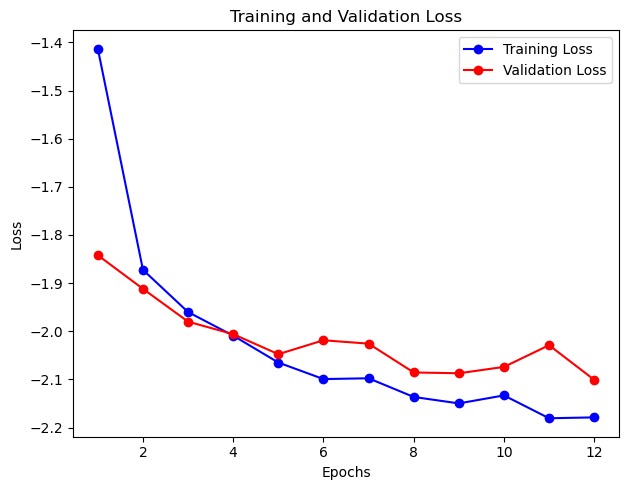

2025-03-11 13:24:25.485408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


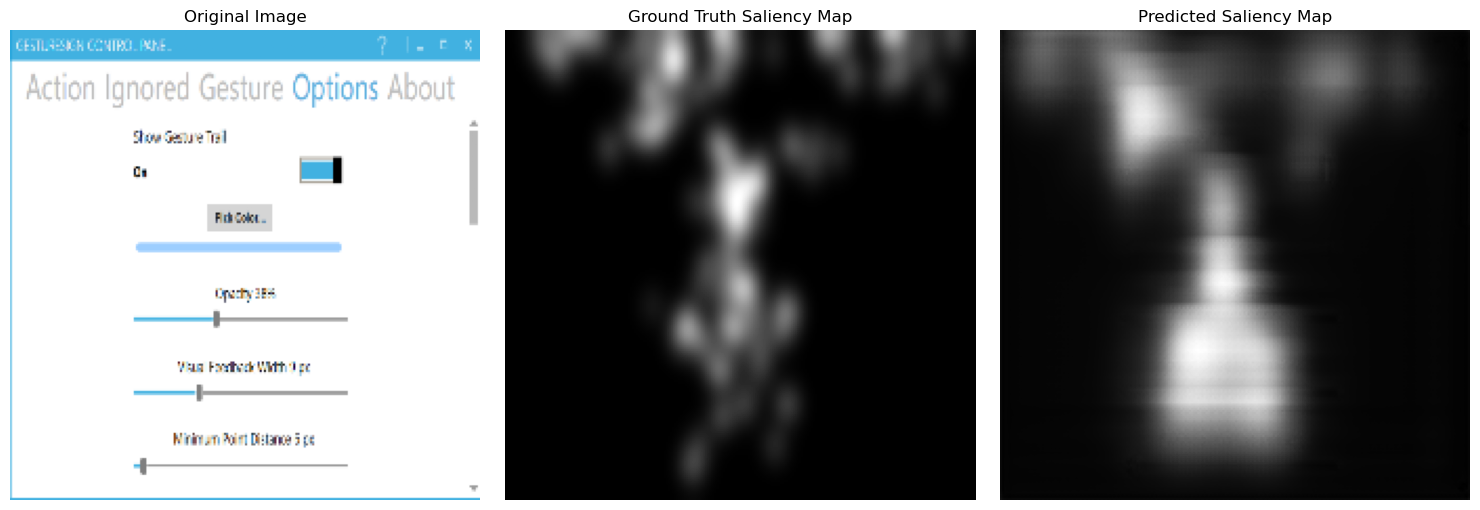

In [ ]:
# train w/ the combined_loss term
'''
kl_weight=1.0 # without scaling kld
cc_weight=1.0
nss_weight=1.0
cs_weight=0.5
'''
UMSI_simple_ = UMSI_simple(input_shape=(224, 224, 3))
UMSI_simple_.compile(optimizer=opt, loss = combined_loss, metrics='mae')
history_simple = UMSI_simple_.fit(train_data_gen, validation_data=valid_data_gen, epochs=12, steps_per_epoch=len(train_data_gen), callbacks=[early_stopping]) #Train the model and capture the history
plot_learning_curve(history_simple)
visualize_results(UMSI_simple_, test_data_gen, num_samples=1) # 5 random test examples

# Model with negative output bias

In [17]:
# Define the UMSI++ model
def UMSI_neg_bias(input_shape=(224, 224, 3)):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # --------------------------
    # Encoder (Feature Extraction)
    # --------------------------
    # Block 1
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x1)
    p1 = MaxPooling2D((2, 2), name='block1_pool')(x1)
    
    # Block 2
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(p1)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x2)
    p2 = MaxPooling2D((2, 2), name='block2_pool')(x2)
    
    # Block 3
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(p2)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2')(x3)
    p3 = MaxPooling2D((2, 2), name='block3_pool')(x3)
    
    # --------------------------
    # Bottleneck (Multi-Scale Feature Aggregation)
    # --------------------------
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same', name='bottleneck_conv1')(p3)
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same', name='bottleneck_conv2')(bottleneck)
    
    # --------------------------
    # Decoder (Saliency Map Reconstruction)
    # --------------------------
    # Block 4
    u4 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='block4_deconv')(bottleneck)
    u4 = concatenate([u4, x3], name='block4_concat')
    u4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(u4)
    u4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(u4)
    
    # Block 5
    u5 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', name='block5_deconv')(u4)
    u5 = concatenate([u5, x2], name='block5_concat')
    u5 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv1')(u5)
    u5 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv2')(u5)
    
    # Block 6
    u6 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', name='block6_deconv')(u5)
    u6 = concatenate([u6, x1], name='block6_concat')
    u6 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block6_conv1')(u6)
    u6 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block6_conv2')(u6)
    
    # --------------------------
    # Saliency Output
    # --------------------------
    # Define a custom bias initializer
    negative_bias_initializer = tf.keras.initializers.Constant(-10.0)  # Adjust the value as needed
    saliency_output = Conv2D(1, (1, 1), activation='sigmoid', name='saliency_output', bias_initializer=negative_bias_initializer)(u6)
    
    # --------------------------
    # Define the Model
    # --------------------------
    model = Model(inputs, saliency_output, name='UMSI_neg_bias')  # Use a valid model name
    
    return model

Epoch 1/12


2025-03-11 13:24:27.615647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: -0.9963 - mae: 0.2417

2025-03-11 13:24:41.023133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 16s 770ms/step - loss: -0.9963 - mae: 0.2417 - val_loss: -1.7515 - val_mae: 0.0771
Epoch 2/12
17/17 [==============================] - 12s 719ms/step - loss: -1.8187 - mae: 0.0767 - val_loss: -1.9130 - val_mae: 0.0770
Epoch 3/12
17/17 [==============================] - 12s 710ms/step - loss: -1.9040 - mae: 0.0769 - val_loss: -1.9268 - val_mae: 0.0770
Epoch 4/12
17/17 [==============================] - 12s 706ms/step - loss: -1.9969 - mae: 0.0774 - val_loss: -2.0218 - val_mae: 0.0771
Epoch 5/12
17/17 [==============================] - 12s 703ms/step - loss: -2.0601 - mae: 0.0770 - val_loss: -2.0495 - val_mae: 0.0771
Epoch 6/12
17/17 [==============================] - 12s 712ms/step - loss: -2.1164 - mae: 0.0771 - val_loss: -2.0746 - val_mae: 0.0770
Epoch 7/12
17/17 [==============================] - 12s 724ms/step - loss: -2.1205 - mae: 0.0771 - val_loss: -2.1051 - val_mae: 0.0770
Epoch 8/12
17/17 [==============================] - 12s 713ms/step

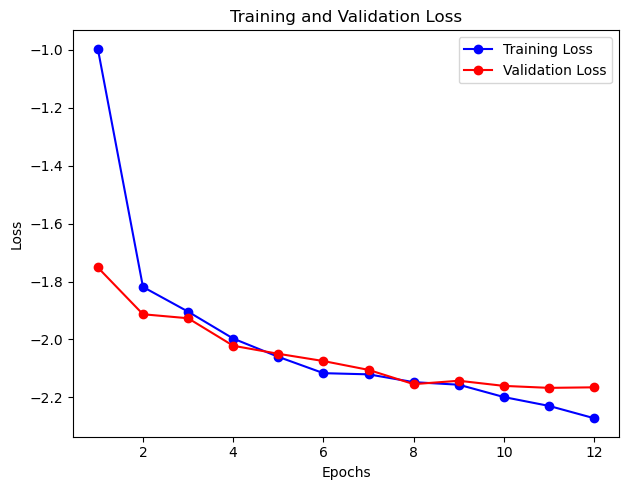

2025-03-11 13:26:58.187383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


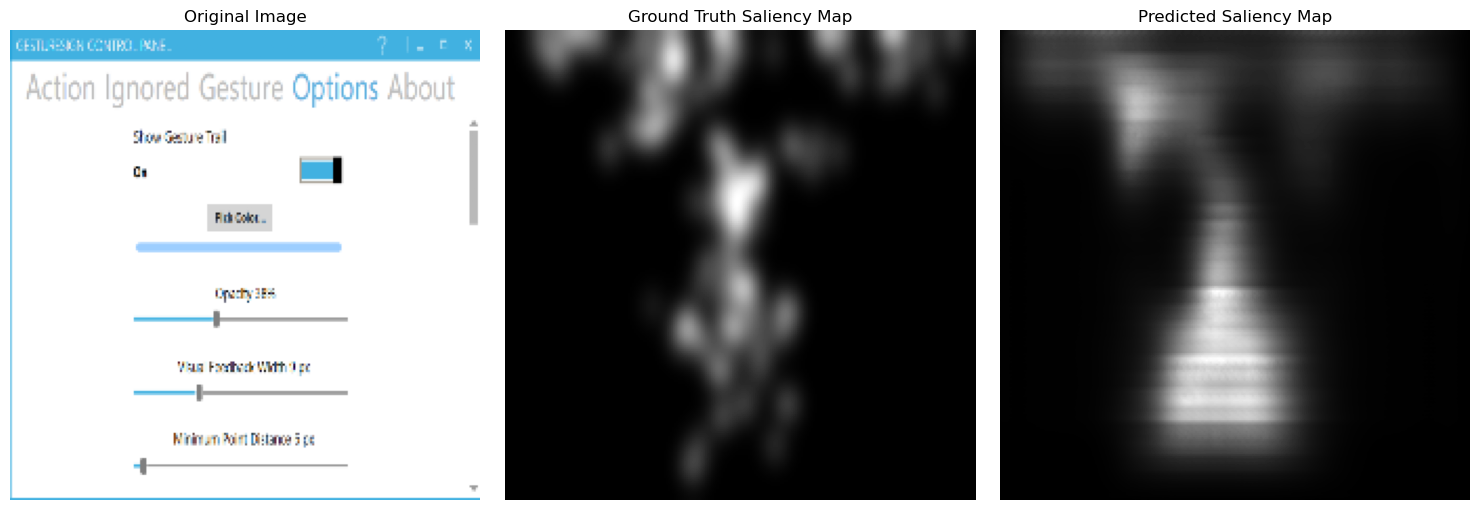

In [ ]:
# train w/ the combined_loss term
'''
kl_weight=1.0 # without scaling kld
cc_weight=1.0
nss_weight=1.0
cs_weight=0.5
'''
UMSI_neg_bias_ = UMSI_neg_bias(input_shape=(224, 224, 3))
UMSI_neg_bias_.compile(optimizer=opt, loss = combined_loss, metrics='mae')
history_neg_bias = UMSI_neg_bias_.fit(train_data_gen, validation_data=valid_data_gen, epochs=12, steps_per_epoch=len(train_data_gen), callbacks=[early_stopping]) #Train the model and capture the history
plot_learning_curve(history_neg_bias)
visualize_results(UMSI_neg_bias_, test_data_gen, num_samples=1) # 5 random test examples

# Model with batch normalization layers
(to combat the potentially vanishing gradient, i.e. why the models with MSE/MAE loss predict fully 0 maps?)

In [19]:
# Define the UMSI++ model
def UMSI_batch_norm(input_shape=(224, 224, 3)):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # --------------------------
    # Encoder (Feature Extraction)
    # --------------------------
    # Block 1
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x1)
    x1 = BatchNormalization(name="block1_conv2_BN")(x1) # added
    p1 = MaxPooling2D((2, 2), name='block1_pool')(x1)
    
    # Block 2
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(p1)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x2)
    x2 = BatchNormalization(name="block2_conv2_BN")(x2) # added
    p2 = MaxPooling2D((2, 2), name='block2_pool')(x2)
    
    # Block 3
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(p2)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2')(x3)
    x3 = BatchNormalization(name="block3_conv2_BN")(x3) # added
    p3 = MaxPooling2D((2, 2), name='block3_pool')(x3)
    
    # --------------------------
    # Bottleneck (Multi-Scale Feature Aggregation)
    # --------------------------
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same', name='bottleneck_conv1')(p3)
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same', name='bottleneck_conv2')(bottleneck)
    bottleneck = BatchNormalization(name="bottleneck_conv2_BN")(bottleneck) # added
    
    # --------------------------
    # Decoder (Saliency Map Reconstruction)
    # --------------------------
    # Block 4
    u4 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='block4_deconv')(bottleneck)
    u4 = concatenate([u4, x3], name='block4_concat')
    u4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(u4)
    u4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(u4)
    u4 = BatchNormalization(name="block4_conv2_BN")(u4) # added
    
    # Block 5
    u5 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', name='block5_deconv')(u4)
    u5 = concatenate([u5, x2], name='block5_concat')
    u5 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv1')(u5)
    u5 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv2')(u5)
    u5 = BatchNormalization(name="block5_conv2_BN")(u5) # added
    
    # Block 6
    u6 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', name='block6_deconv')(u5)
    u6 = concatenate([u6, x1], name='block6_concat')
    u6 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block6_conv1')(u6)
    u6 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block6_conv2')(u6)
    
    # --------------------------
    # Saliency Output
    # --------------------------
    saliency_output = Conv2D(1, (1, 1), activation='sigmoid', name='saliency_output')(u6)
    
    # --------------------------
    # Define the Model
    # --------------------------
    model = Model(inputs, saliency_output, name='UMSI_neg_bias')  # Use a valid model name
    
    return model

Epoch 1/12


2025-03-11 13:26:59.899483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 0.0400 - mae: 0.1166

2025-03-11 13:27:13.942252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 16s 763ms/step - loss: 0.0400 - mae: 0.1166 - val_loss: 0.0258 - val_mae: 0.0775
Epoch 2/12
17/17 [==============================] - 12s 722ms/step - loss: 0.0236 - mae: 0.0785 - val_loss: 0.0258 - val_mae: 0.0773
Epoch 3/12
17/17 [==============================] - 13s 766ms/step - loss: 0.0218 - mae: 0.0770 - val_loss: 0.0295 - val_mae: 0.1046
Epoch 4/12
17/17 [==============================] - 13s 747ms/step - loss: 0.0187 - mae: 0.0744 - val_loss: 0.0261 - val_mae: 0.1303
Epoch 5/12
17/17 [==============================] - 16s 939ms/step - loss: 0.0164 - mae: 0.0723 - val_loss: 0.0294 - val_mae: 0.1232


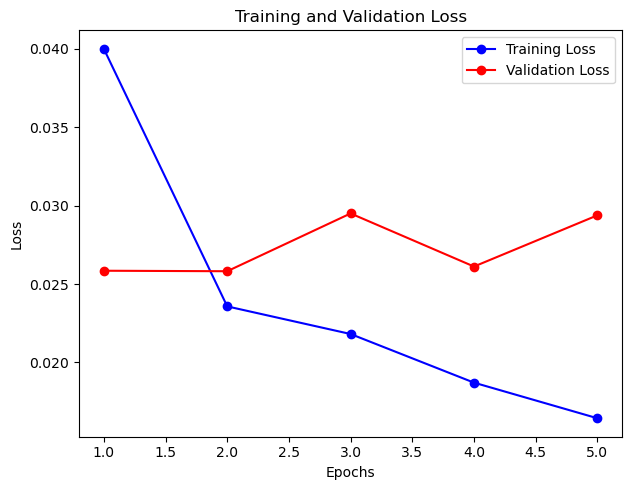

2025-03-11 13:28:10.931809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


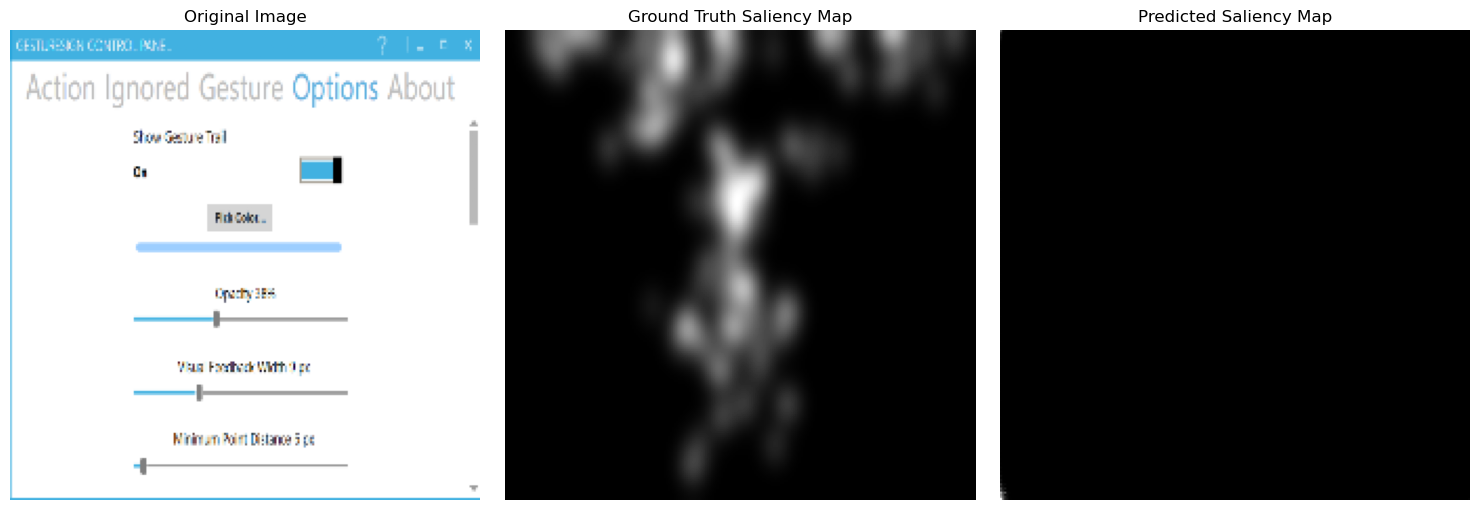

In [ ]:
# train w/ mse or mae
UMSI_batch_norm_MSE = UMSI_batch_norm(input_shape=(224, 224, 3))
UMSI_batch_norm_MSE.compile(optimizer=opt, loss = 'mse', metrics='mae')
history_MSE = UMSI_batch_norm_MSE.fit(train_data_gen, validation_data=valid_data_gen, epochs=12, steps_per_epoch=len(train_data_gen), callbacks=[early_stopping]) #Train the model and capture the history
plot_learning_curve(history_MSE)
visualize_results(UMSI_batch_norm_MSE, test_data_gen, num_samples=1) # 5 random test examples

still didn't fix the problem with using MSE/MAE loss

Epoch 1/12


2025-03-11 13:28:14.185880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: -1.4495 - mae: 0.3756

2025-03-11 13:28:30.809950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 21s 972ms/step - loss: -1.4495 - mae: 0.3756 - val_loss: -0.4268 - val_mae: 0.9110
Epoch 2/12
17/17 [==============================] - 14s 824ms/step - loss: -1.9050 - mae: 0.2033 - val_loss: -0.6575 - val_mae: 0.8311
Epoch 3/12
17/17 [==============================] - 14s 831ms/step - loss: -1.9902 - mae: 0.2010 - val_loss: -0.5824 - val_mae: 0.3286
Epoch 4/12
17/17 [==============================] - 17s 973ms/step - loss: -2.0544 - mae: 0.1639 - val_loss: -1.0272 - val_mae: 0.1329
Epoch 5/12
17/17 [==============================] - 14s 821ms/step - loss: -2.1036 - mae: 0.1493 - val_loss: -0.5512 - val_mae: 0.0759
Epoch 6/12
17/17 [==============================] - 14s 809ms/step - loss: -2.1453 - mae: 0.1213 - val_loss: -1.0968 - val_mae: 0.0742
Epoch 7/12
17/17 [==============================] - 14s 799ms/step - loss: -2.1914 - mae: 0.1288 - val_loss: -0.8625 - val_mae: 0.0845
Epoch 8/12
17/17 [==============================] - 14s 801ms/step

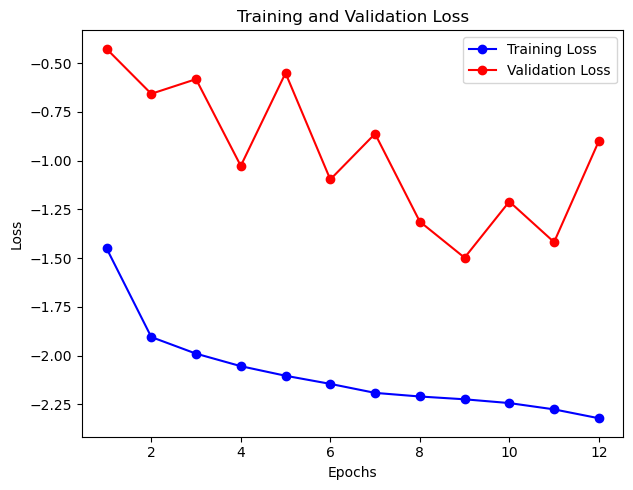

2025-03-11 13:31:15.206860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


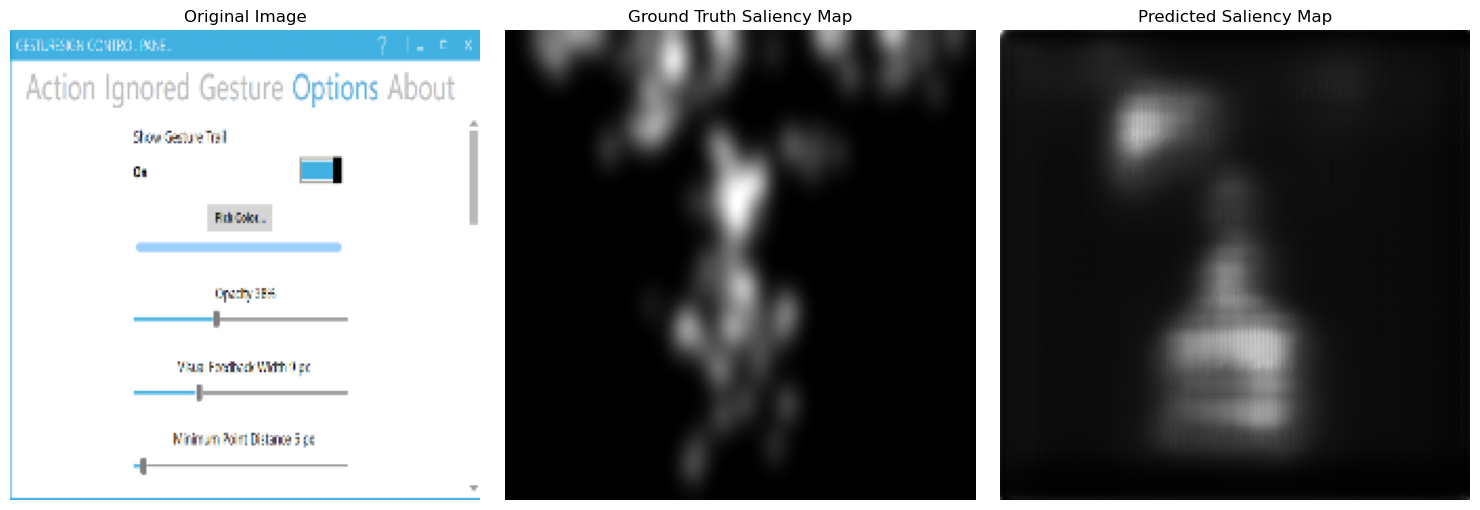

In [ ]:
# train w/ the combined_loss term
'''
kl_weight=1.0 # without scaling kld
cc_weight=1.0
nss_weight=1.0
cs_weight=0.5
'''
UMSI_batch_norm_ = UMSI_batch_norm(input_shape=(224, 224, 3))
UMSI_batch_norm_.compile(optimizer=opt, loss = combined_loss, metrics='mae')
history_batch_norm = UMSI_batch_norm_.fit(train_data_gen, validation_data=valid_data_gen, epochs=12, steps_per_epoch=len(train_data_gen), callbacks=[early_stopping]) #Train the model and capture the history
plot_learning_curve(history_batch_norm)
visualize_results(UMSI_batch_norm_, test_data_gen, num_samples=1) # 5 random test examples

# Model with L2 regularizers and dropout layers (in decoder) to prevent overfitting

remove batch normalization layers after pooling layers, add them after bottleneck layer
**specified weight initializations to try to address vanishing gradients** and **added weight regularizers and dropout layers to prevent overfitting** (training for a few more epochs bc added regularizations)

In [15]:
# Define the UMSI++ model
def UMSI_regularized(input_shape=(224, 224, 3)):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # --------------------------
    # Encoder (Feature Extraction)
    # --------------------------
    # Block 1
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(inputs)
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x1)
    p1 = MaxPooling2D((2, 2), name='block1_pool')(x1)
    
    # Block 2
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(p1)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x2)
    p2 = MaxPooling2D((2, 2), name='block2_pool')(x2)
    
    # Block 3
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(p2)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2')(x3)
    p3 = MaxPooling2D((2, 2), name='block3_pool')(x3)
    
    # --------------------------
    # Bottleneck (Multi-Scale Feature Aggregation)
    # --------------------------
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same', name='bottleneck_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(p3)
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same', name='bottleneck_conv2')(bottleneck)
    
    # --------------------------
    # Decoder (Saliency Map Reconstruction)
    # --------------------------
    # Block 4
    u4 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='block4_deconv')(bottleneck)
    u4 = concatenate([u4, x3], name='block4_concat')
    u4 = Dropout(0.3)(u4) # added
    u4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(u4)
    u4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(u4)
    
    # Block 5
    u5 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', name='block5_deconv')(u4)
    u5 = concatenate([u5, x2], name='block5_concat')
    u5 = Dropout(0.3)(u5) # added
    u5 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(u5)
    u5 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv2')(u5)
    
    # Block 6
    u6 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', name='block6_deconv')(u5)
    u6 = concatenate([u6, x1], name='block6_concat')
    u6 = Dropout(0.3)(u6) # added
    u6 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block6_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(u6)
    u6 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block6_conv2')(u6)
    u6 = Dropout(0.3)(u6) # added
    
    # --------------------------
    # Saliency Output
    # --------------------------
    saliency_output = Conv2D(1, (1, 1), activation='sigmoid', name='saliency_output')(u6)
    
    # --------------------------
    # Define the Model
    # --------------------------
    model = Model(inputs, saliency_output, name='UMSI_neg_bias')  # Use a valid model name
    
    return model

Epoch 1/12


2025-03-11 16:17:54.649047: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-03-11 16:17:56.303103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: -1.2400 - mae: 0.5493

2025-03-11 16:18:13.191135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 20s 973ms/step - loss: -1.2400 - mae: 0.5493 - val_loss: -1.7819 - val_mae: 0.5222
Epoch 2/12
17/17 [==============================] - 16s 906ms/step - loss: -1.7892 - mae: 0.5268 - val_loss: -1.8903 - val_mae: 0.4892
Epoch 3/12
17/17 [==============================] - 14s 834ms/step - loss: -1.8903 - mae: 0.5111 - val_loss: -1.9339 - val_mae: 0.5372
Epoch 4/12
17/17 [==============================] - 15s 842ms/step - loss: -1.9516 - mae: 0.4960 - val_loss: -1.9939 - val_mae: 0.5151
Epoch 5/12
17/17 [==============================] - 14s 826ms/step - loss: -1.9932 - mae: 0.4862 - val_loss: -1.9878 - val_mae: 0.4565
Epoch 6/12
17/17 [==============================] - 15s 841ms/step - loss: -2.0347 - mae: 0.4925 - val_loss: -2.0154 - val_mae: 0.5230
Epoch 7/12
17/17 [==============================] - 15s 878ms/step - loss: -2.0438 - mae: 0.4749 - val_loss: -2.0208 - val_mae: 0.4557
Epoch 8/12
17/17 [==============================] - 15s 874ms/step

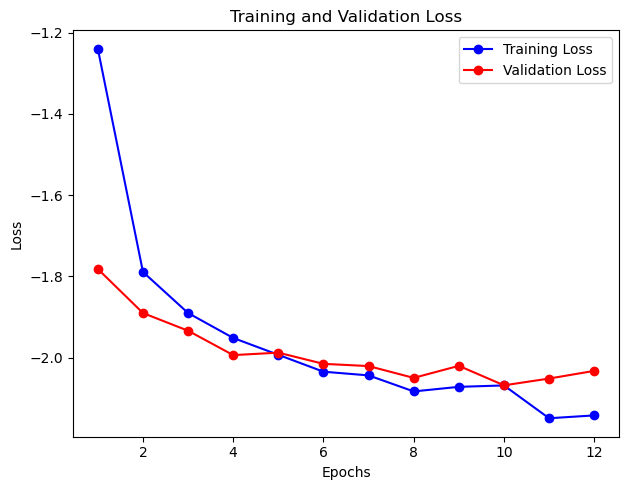

2025-03-11 16:21:04.598387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


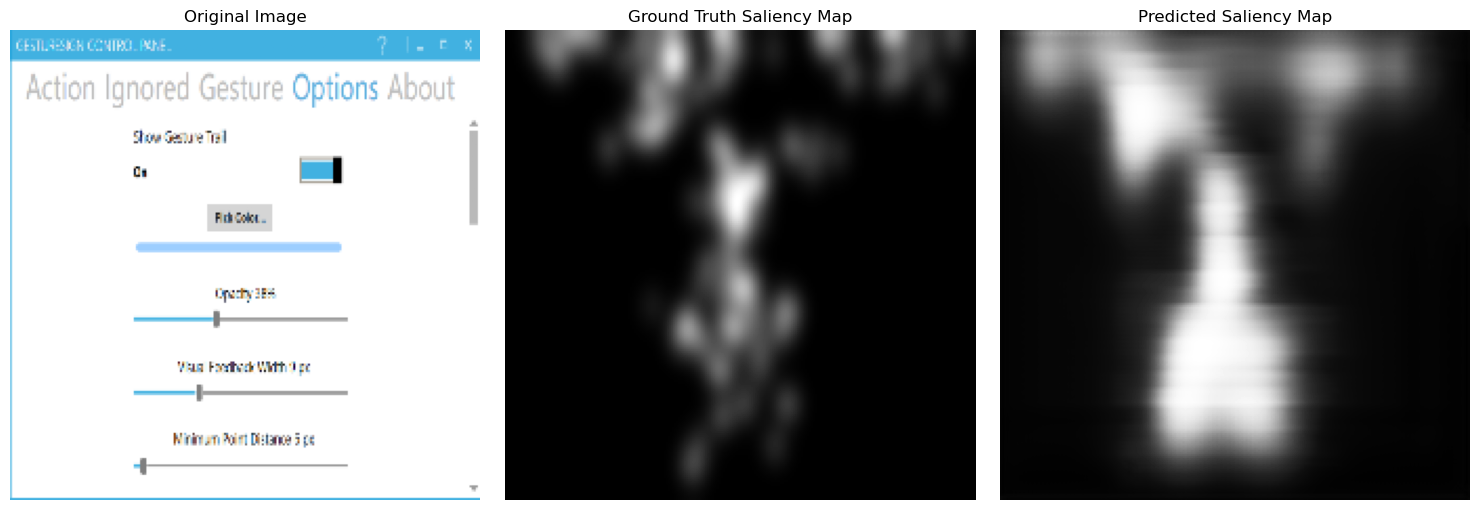

In [16]:
# train w/ the combined_loss term
'''
kl_weight=1.0 # without scaling kld
cc_weight=1.0
nss_weight=1.0
cs_weight=0.5
'''
UMSI_regularized_ = UMSI_regularized(input_shape=(224, 224, 3))
UMSI_regularized_.compile(optimizer=opt, loss = combined_loss, metrics='mae')
history_regularized = UMSI_regularized_.fit(train_data_gen, validation_data=valid_data_gen, epochs=12, steps_per_epoch=len(train_data_gen), callbacks=[early_stopping]) #Train the model and capture the history
plot_learning_curve(history_regularized)
visualize_results(UMSI_regularized_, test_data_gen, num_samples=1) # 5 random test examples

# Visualize how these models do on trianing data

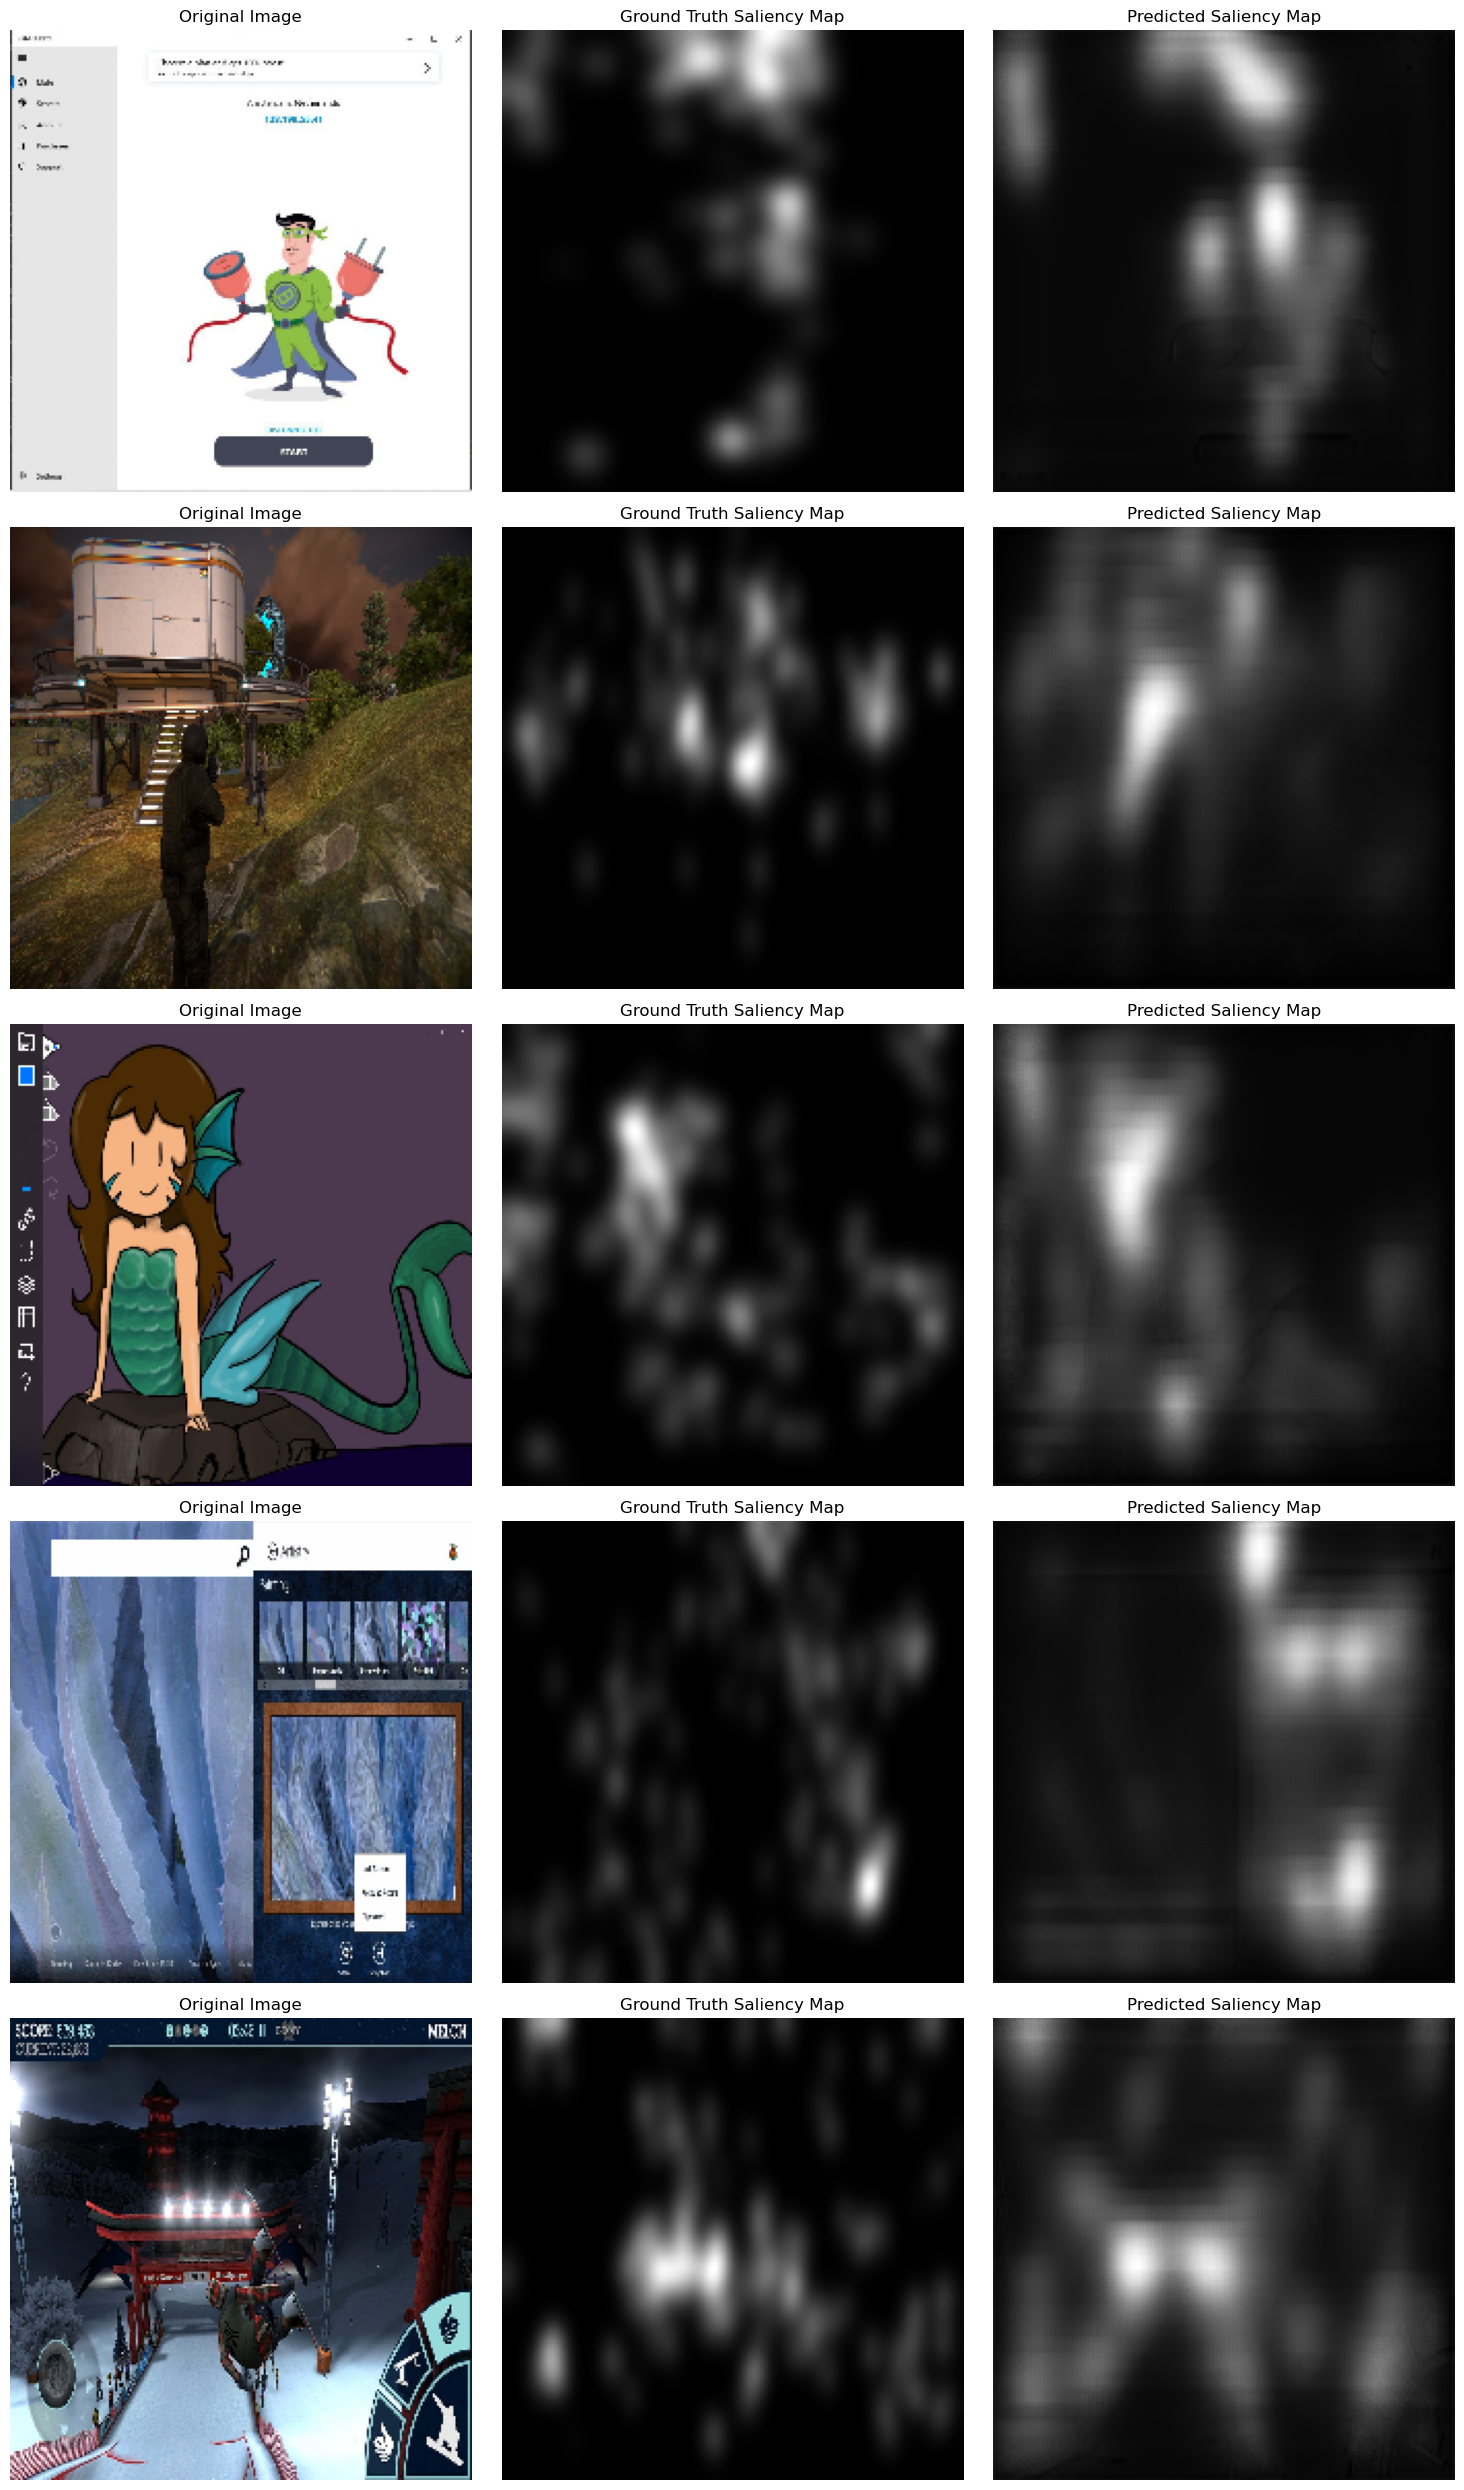

In [32]:
visualize_results(UMSI_simple_, train_data_gen, num_samples=5) # 5 random test examples

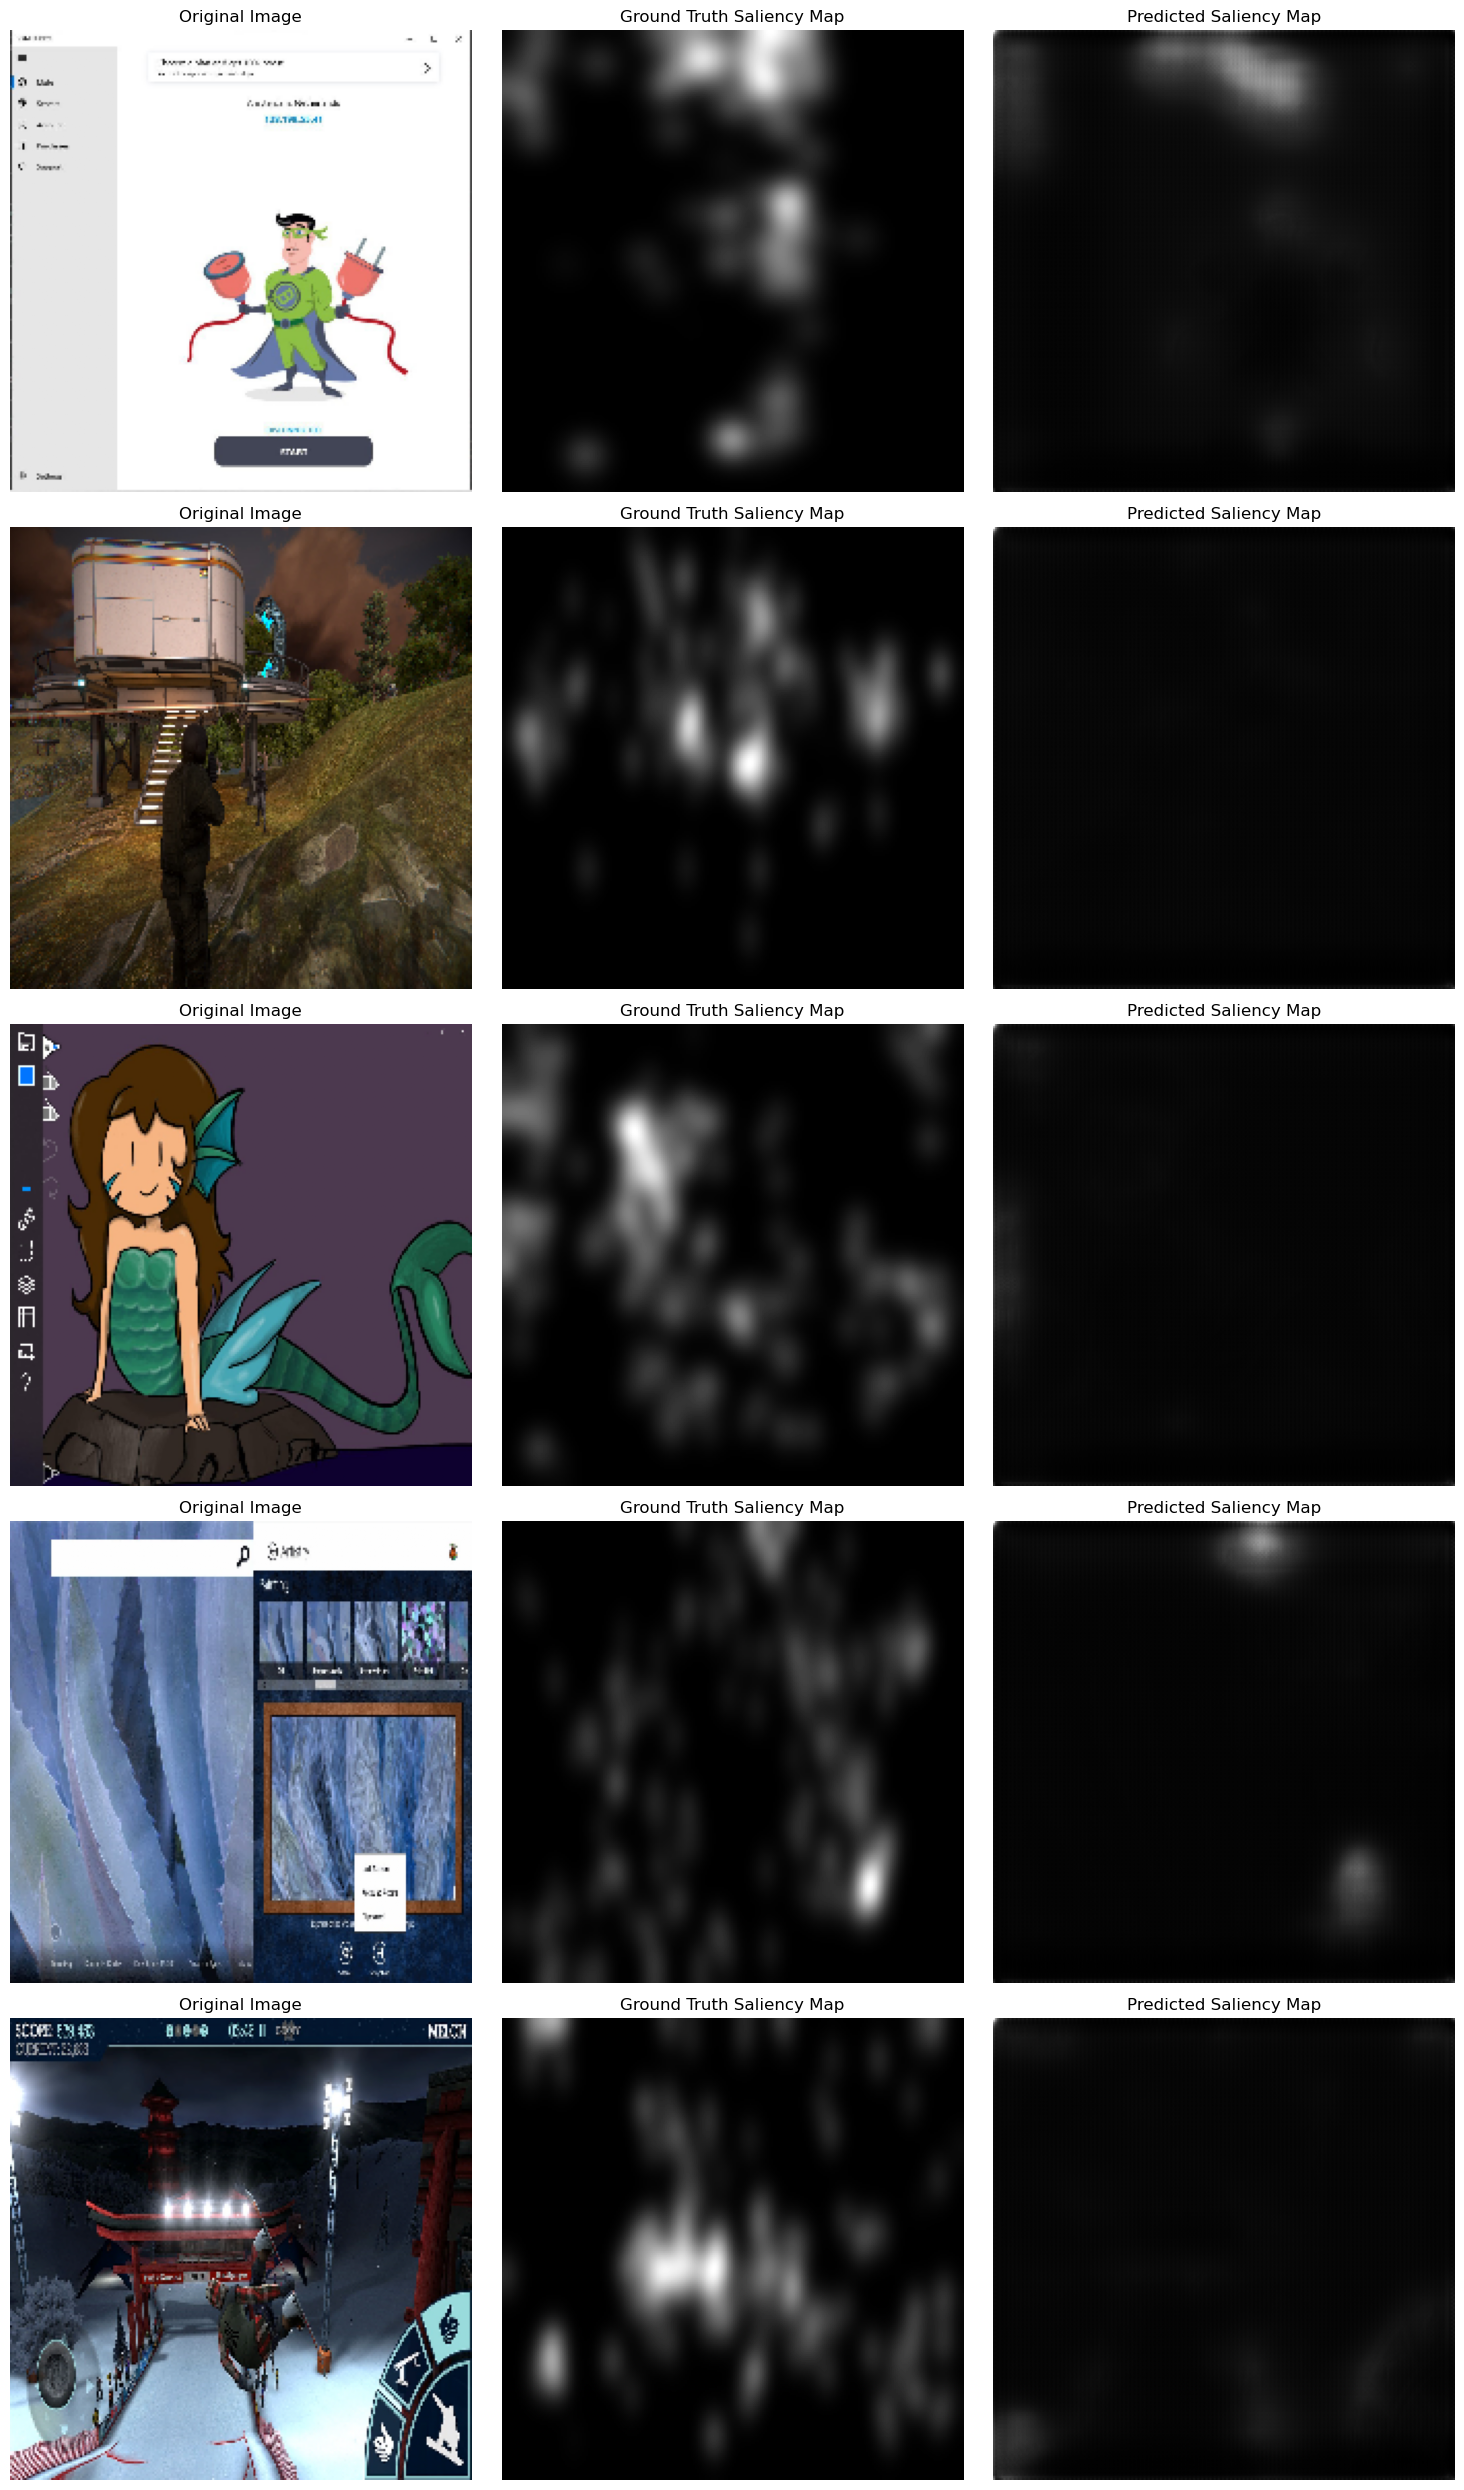

In [33]:
visualize_results(UMSI_batch_norm_, train_data_gen, num_samples=5) # 5 random test examples

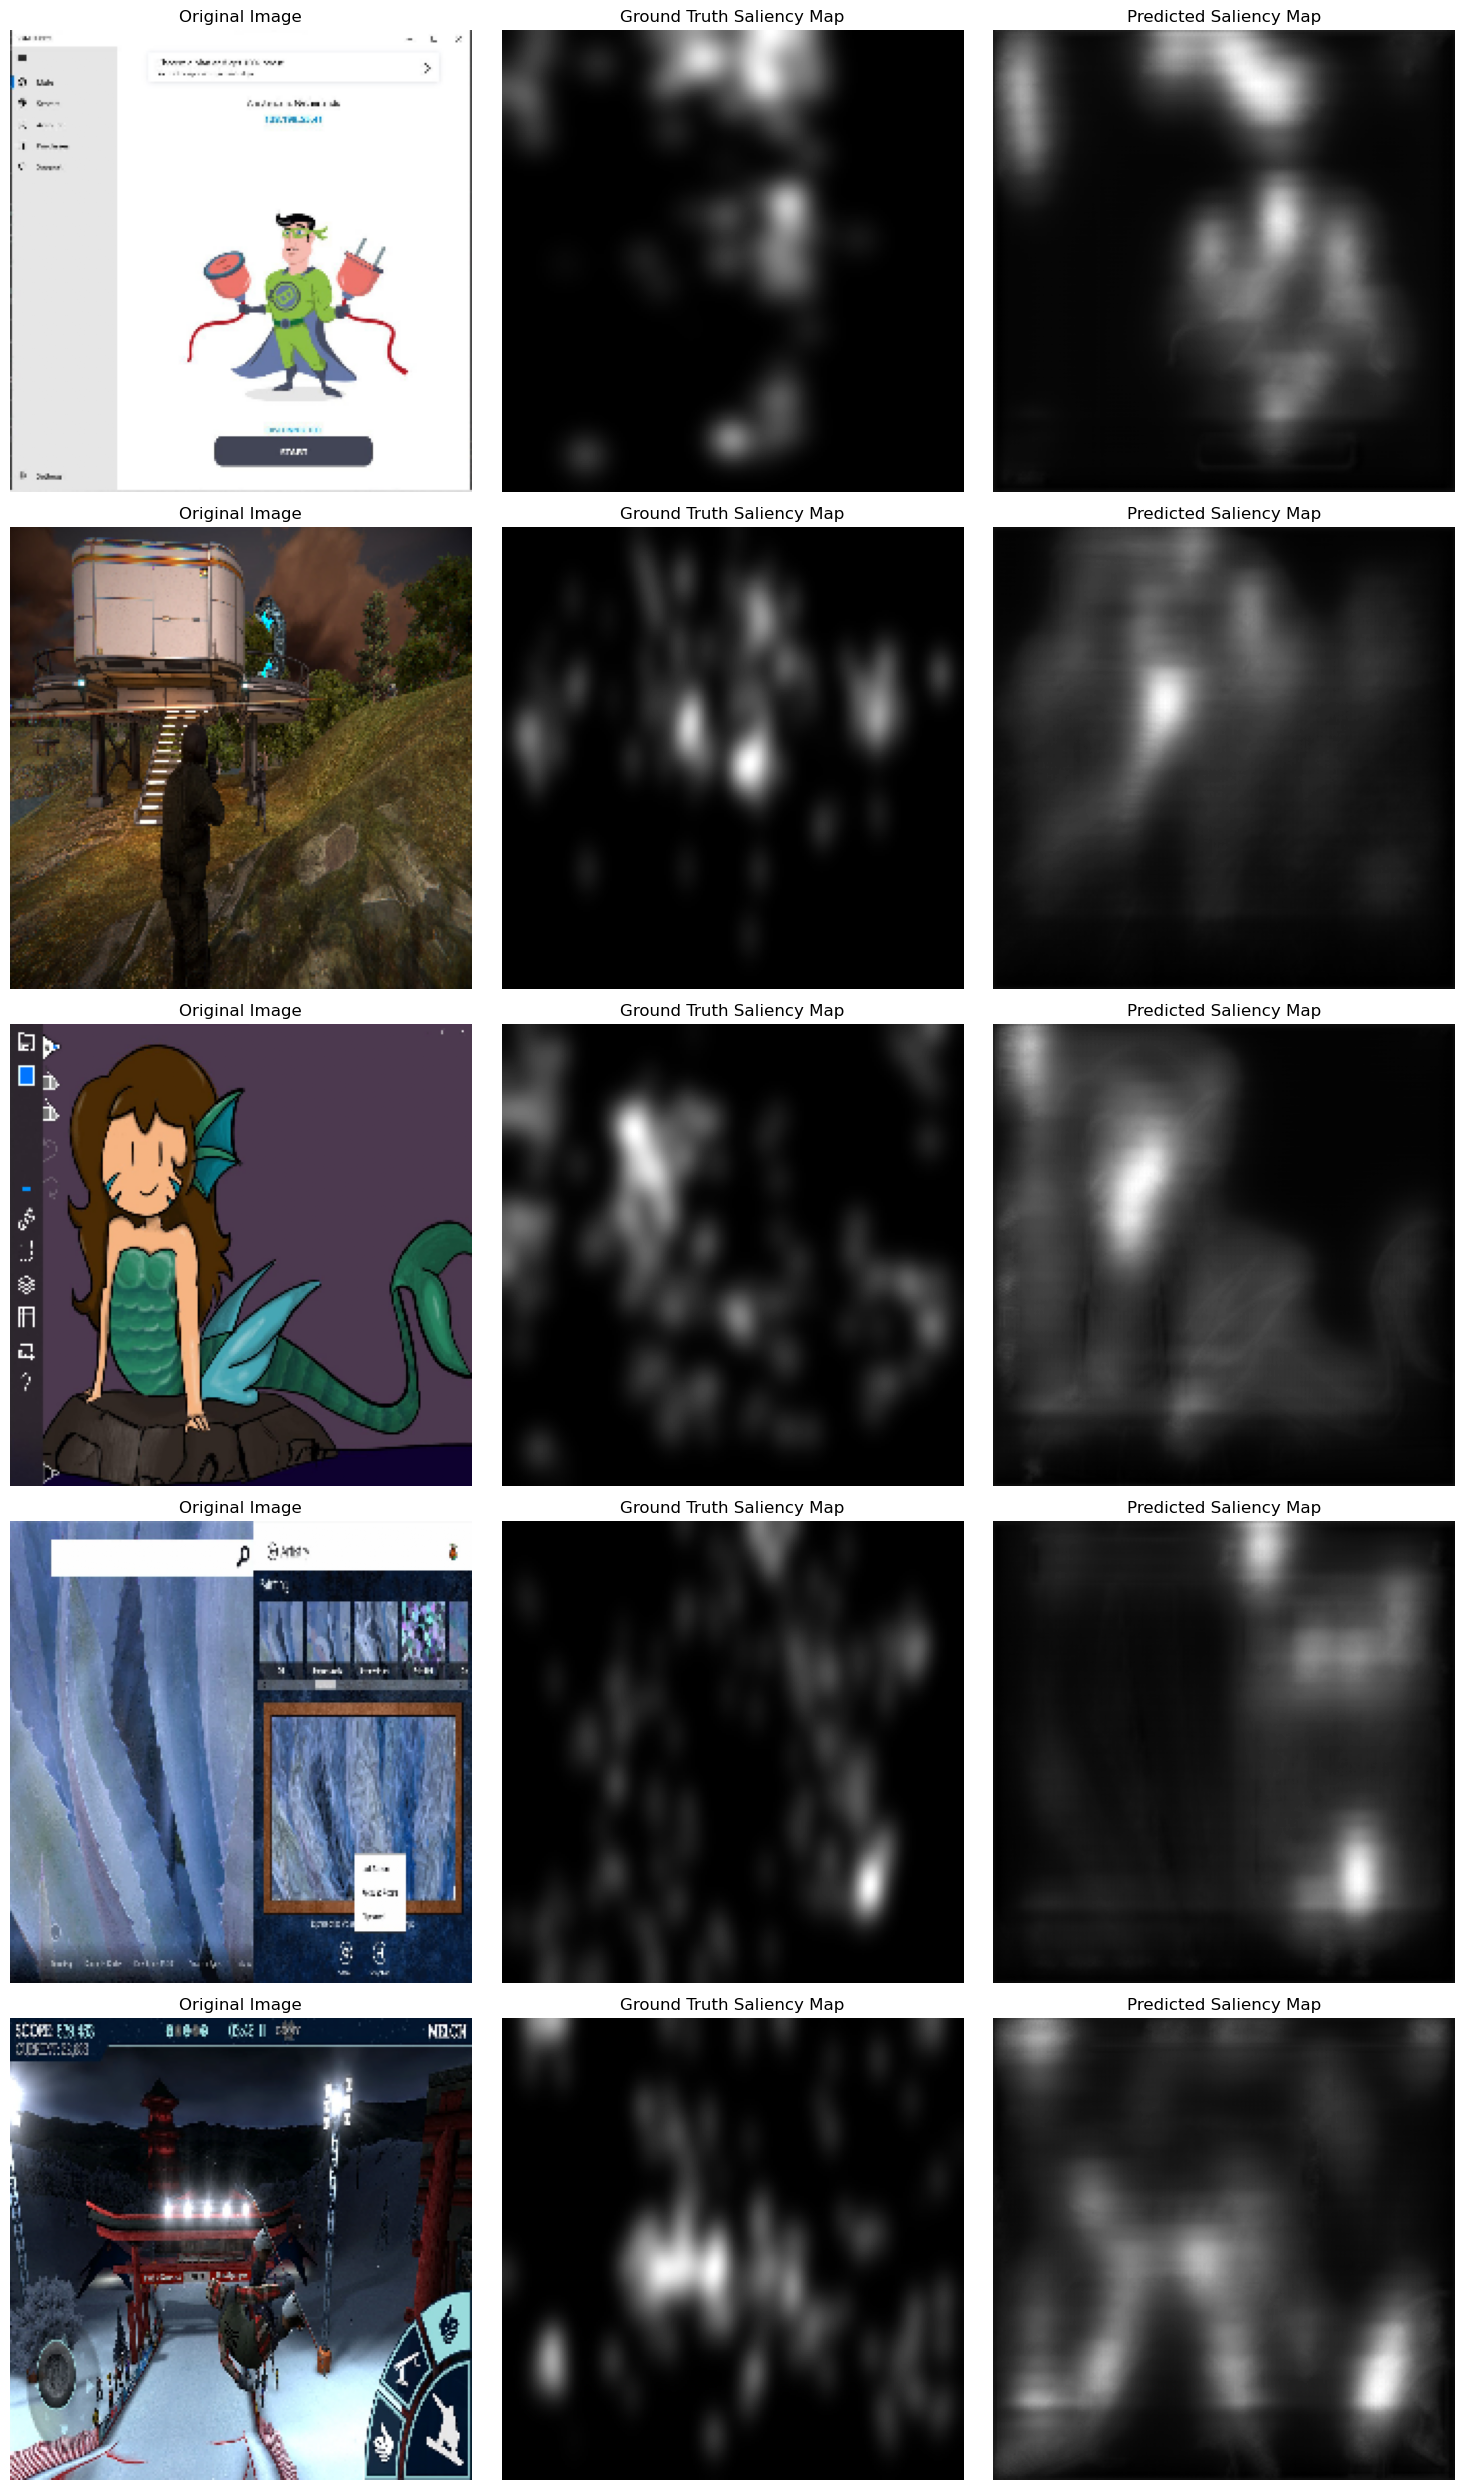

In [31]:
visualize_results(UMSI_regularized_, train_data_gen, num_samples=5) # 5 random test examples

the original simple model still seems to reproduce the ground truth the best...though the regularized one has potential

# Evalute the models' performance on test data

In [34]:
train_test_performance(UMSI_simple_)

loss               mae
Train -2.100749969482422 0.403537094593048
Test  -1.996015310287476 0.425501853227615

In [35]:
train_test_performance(UMSI_batch_norm_)

loss               mae
Train -0.899895668029785 0.076491355895996
Test  -1.536736845970154 0.069894261658192

In [36]:
train_test_performance(UMSI_regularized_)

loss               mae
Train -1.993320822715759 0.536318540573120
Test  -1.926728010177612 0.477817833423615